In [ ]:
from __future__ import print_function
%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
#Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
imgSize=64
# Batch size during training
batchSize=64
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of channels in the training images.
nc=1
# Learning rate for optimizers
lr=0.0002
# Beta1 hyperparam for Adam optimizers
beta1=0.5
# Number of training epochs
niter=10
# Number of workers for dataloader
workers=2

In [ ]:
dataset = dset.MNIST(root='../../data', download=True,
                           transform=transforms.Compose([
                               transforms.Resize(imgSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         num_workers=workers,
                                         shuffle=True)

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


In [ ]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

In [ ]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == niter-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1   
   


/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[0/10][0/938] Loss_D: 1.5167 Loss_G: 3.0218 D(x): 0.4481 D(G(z)): 0.3885 / 0.0660
[0/10][1/938] Loss_D: 2.0149 Loss_G: 5.0809 D(x): 0.9988 D(G(z)): 0.8184 / 0.0091
[0/10][2/938] Loss_D: 0.6309 Loss_G: 6.6760 D(x): 0.9958 D(G(z)): 0.4090 / 0.0022
[0/10][3/938] Loss_D: 0.2596 Loss_G: 6.6825 D(x): 0.9955 D(G(z)): 0.1995 / 0.0021
[0/10][4/938] Loss_D: 0.2409 Loss_G: 6.4222 D(x): 0.9649 D(G(z)): 0.1540 / 0.0027
[0/10][5/938] Loss_D: 0.3288 Loss_G: 7.1459 D(x): 0.9341 D(G(z)): 0.2040 / 0.0012
[0/10][6/938] Loss_D: 0.2689 Loss_G: 6.6594 D(x): 0.8919 D(G(z)): 0.0927 / 0.0022
[0/10][7/938] Loss_D: 0.2163 Loss_G: 7.3371 D(x): 0.9569 D(G(z)): 0.1394 / 0.0010
[0/10][8/938] Loss_D: 0.2753 Loss_G: 8.4623 D(x): 0.9322 D(G(z)): 0.1609 / 0.0004
[0/10][9/938] Loss_D: 0.1366 Loss_G: 7.5119 D(x): 0.9474 D(G(z)): 0.0557 / 0.0008
[0/10][10/938] Loss_D: 0.2055 Loss_G: 8.7213 D(x): 0.9509 D(G(z)): 0.1244 / 0.0003
[0/10][11/938] Loss_D: 0.1857 Loss_G: 7.2773 D(x): 0.9034 D(G(z)): 0.0517 / 0.0011
[0/10][12/938]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
[4/10][629/938] Loss_D: 0.6738 Loss_G: 5.8389 D(x): 0.9817 D(G(z)): 0.4309 / 0.0043
[4/10][630/938] Loss_D: 0.6097 Loss_G: 2.2668 D(x): 0.5847 D(G(z)): 0.0101 / 0.1617
[4/10][631/938] Loss_D: 0.6144 Loss_G: 5.7192 D(x): 0.9917 D(G(z)): 0.3921 / 0.0050
[4/10][632/938] Loss_D: 0.3008 Loss_G: 3.7295 D(x): 0.7951 D(G(z)): 0.0430 / 0.0391
[4/10][633/938] Loss_D: 0.2148 Loss_G: 2.5400 D(x): 0.8736 D(G(z)): 0.0484 / 0.1154
[4/10][634/938] Loss_D: 0.2816 Loss_G: 4.3631 D(x): 0.9651 D(G(z)): 0.1882 / 0.0192
[4/10][635/938] Loss_D: 0.1422 Loss_G: 4.7052 D(x): 0.9283 D(G(z)): 0.0584 / 0.0153
[4/10][636/938] Loss_D: 0.2212 Loss_G: 2.7793 D(x): 0.8575 D(G(z)): 0.0504 / 0.1008
[4/10][637/938] Loss_D: 0.2139 Loss_G: 4.3657 D(x): 0.9616 D(G(z)): 0.1407 / 0.0228
[4/10][638/938] Loss_D: 0.1435 Loss_G: 4.4151 D(x): 0.9314 D(G(z)): 0.0625 / 0.0186
[4/10][639/938] Loss_D: 0.1538 Loss_G: 3.5825 D(x): 0.8972 D(G(z)): 0.0350 / 0.0462
[4/10][640/938] Loss_D: 0

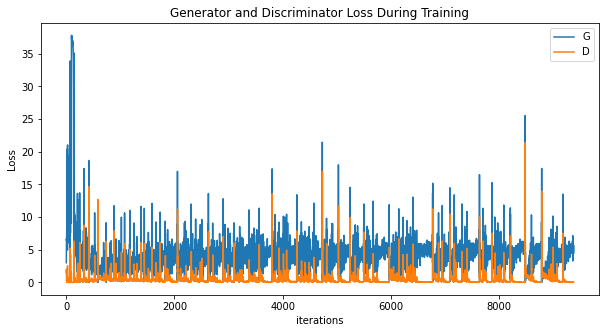

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

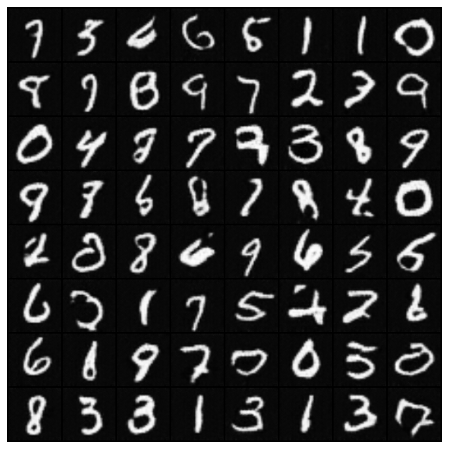

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

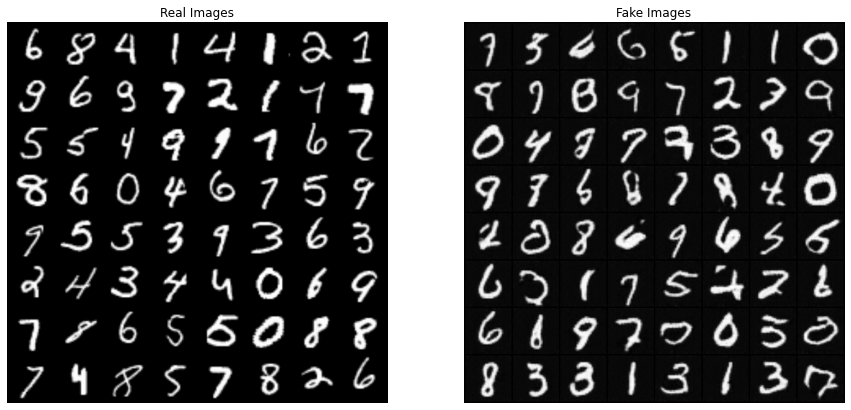

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()